## Abstract
Despite the fact that the agricultural sector is a national economic development priority in sub-Saharan Africa, crop pests and diseases have been the challenge affecting major food security crops like maize. 
Maize Streak Disease which is caused by the Maize Streak Virus is regarded as the third most serious disease affecting maize in sub-Saharan Africa. 
The prominence of this disease has greatly affected the yields of Africa’s most important food crop. 

## Classes
<div style="display: flex; justify-content: center;">
    <div style="text-align: center; margin-right: 20px;">
        <p>Healthy</p>
        <img src="sample/1621590060253.jpg" alt="Image 1" style="width: 200;">
    </div>
    <div style="text-align: center;">
        <p>Maize Streak Virus</p>
        <img src="sample/1621319276554.jpg" alt="Image 2" style="width: 200;">
    </div>
</div>


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
%pip install keras-tuner
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
import numpy as np
import os
import json
import zipfile
%pip install mlflow
import mlflow
from urllib.parse import urlparse
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import gdown
%pip install opencv-python
import cv2


import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.4 MB/s eta 0:00:00


<ipython-input-1-f7b566e6f870>:10: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.2/20.2 MB 43.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.6/147.6 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.9/202.9 kB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 8.0 MB/s eta 0:00:00


## Downloading and extracting the dataset from Google Drive

In [2]:
try:
  dataset_url = "https://drive.google.com/file/d/1GIs3v_e3ki_c5Z3FgAx4qxMf_ypXiS8r/view?usp=sharing"
  zip_download_dir =  "content/"
  file_id = dataset_url.split("/")[-2]
  prefix = "https://drive.google.com/uc?/export=download&id="
  gdown.download(prefix + file_id, zip_download_dir)

except Exception as e:
  raise e

Downloading...
From (original): https://drive.google.com/uc?/export=download&id=1GIs3v_e3ki_c5Z3FgAx4qxMf_ypXiS8r
From (redirected): https://drive.google.com/uc?%2Fexport=download&id=1GIs3v_e3ki_c5Z3FgAx4qxMf_ypXiS8r&confirm=t&uuid=142105d1-f234-4d6b-9b1a-5beae05a5391
To: /content/content/msv_dataset.zip
100%|██████████| 865M/865M [00:10<00:00, 84.5MB/s]


In [3]:
try:
  with zipfile.ZipFile('content/msv_dataset.zip', "r") as zip_ref:
      zip_ref.extractall('content/')

except Exception as e:
  raise e

## Hyperparameters & mlflow configs

In [4]:
params = {
    "LEARNING_RATE": 0.01,
    "CLASSES": 2,
    "EPOCHS": 30,
    "BATCH_SIZE": 64,
    "IMAGE_SIZE": [224, 224, 3],
}

In [5]:
data = 'content/msv_dataset'

In [6]:
# mlflow configs
MLFLOW_TRACKING_URI = "https://dagshub.com/kalema3502/maize-streak-virus-classification.mlflow"
MLFLOW_TRACKING_USERNAME = "kalema3502"
MLFLOW_TRACKING_PASSWORD = "fb3845efcc3b2e46a4157b1d2c977a21e02dd16e"

## Generating train and validation sets

In [7]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    directory=data,
    target_size=params['IMAGE_SIZE'][:-1],
    batch_size=params['BATCH_SIZE'],
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    directory=data,
    target_size=params['IMAGE_SIZE'][:-1],
    batch_size=params['BATCH_SIZE'],
    class_mode='categorical',
    subset='validation'
)

Found 960 images belonging to 2 classes.
Found 240 images belonging to 2 classes.


## Using keras-tuner to obtain the model architecture that gives us the best validation loss(val_loss). This is the model architecture we shall use

In [ ]:
def build_model(hp):
    model = Sequential()

    # Add Conv2D layers with hyperparameter search for filters
    model.add(Conv2D(
        filters=hp.Int('conv1_filters', min_value=32, max_value=128, step=32),
        kernel_size=(3, 3),
        activation='relu',
        input_shape=(224, 224, 3)
    ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(
        filters=hp.Int('conv2_filters', min_value=32, max_value=128, step=32),
        kernel_size=(3, 3),
        activation='relu'
    ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(
        filters=hp.Int('conv3_filters', min_value=32, max_value=128, step=32),
        kernel_size=(3, 3),
        activation='relu'
    ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(
        filters=hp.Int('conv4_filters', min_value=32, max_value=128, step=32),
        kernel_size=(3, 3),
        activation='relu'
    ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    # Add Dense layer with hyperparameter search for units
    model.add(Dense(
        units=hp.Int('dense_units', min_value=128, max_value=512, step=64),
        activation='relu'
    ))

    # Output layer with softmax activation
    model.add(Dense(params['CLASSES'], activation='softmax'))

    # Compile the model
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Define hyperparameter search space
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    directory='content/',
    project_name='msv_classification'
)

tuner.search(
    train_generator,
    epochs=20,
    validation_data=validation_generator
)

# Retrieve the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]


Trial 10 Complete [00h 06m 26s]
val_loss: 0.18363338708877563

Best val_loss So Far: 0.18363338708877563
Total elapsed time: 01h 08m 05s


## The best model architecture
Hyperparameters:
- conv1_filters: 64
- conv2_filters: 32
- conv3_filters: 128
- conv4_filters: 32
- dense_units: 128
- Score: 0.18363338708877563(best val_loss)

In [ ]:
tuner.results_summary()

Results summary
Results in content/msv_classification
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 09 summary
Hyperparameters:
conv1_filters: 64
conv2_filters: 32
conv3_filters: 128
conv4_filters: 32
dense_units: 128
Score: 0.18363338708877563

Trial 06 summary
Hyperparameters:
conv1_filters: 32
conv2_filters: 128
conv3_filters: 128
conv4_filters: 96
dense_units: 448
Score: 0.19746382534503937

Trial 05 summary
Hyperparameters:
conv1_filters: 96
conv2_filters: 96
conv3_filters: 32
conv4_filters: 96
dense_units: 448
Score: 0.19996623694896698

Trial 08 summary
Hyperparameters:
conv1_filters: 96
conv2_filters: 32
conv3_filters: 96
conv4_filters: 96
dense_units: 448
Score: 0.21016378700733185

Trial 03 summary
Hyperparameters:
conv1_filters: 64
conv2_filters: 128
conv3_filters: 96
conv4_filters: 96
dense_units: 128
Score: 0.23252776265144348

Trial 01 summary
Hyperparameters:
conv1_filters: 128
conv2_filters: 128
conv3_filters: 96
conv4_filters: 64
dense_units

In [8]:
params["CONV2D_1_FILTERS"] = 64,
params["CONV2D_2_FILTERS"] = 32,
params["CONV2D_3_FILTERS"] = 128,
params["CONV2D_4_FILTERS"] = 32,
params["DENSE_UNITS"] = 320

## Building model using best model hyperparameters

In [9]:
model = Sequential([
    Conv2D(params["CONV2D_1_FILTERS"][0], (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(params["CONV2D_2_FILTERS"][0], (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(params["CONV2D_3_FILTERS"][0], (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(params["CONV2D_4_FILTERS"][0], (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(params["DENSE_UNITS"], activation='relu'),
    Dense(2, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       36992     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

## Training
We use ModelCheckPoint to save the best model in every training session

In [10]:
from datetime import datetime
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

os.makedirs('artifacts/', exist_ok=True)

steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = validation_generator.samples // validation_generator.batch_size

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=1e-5)

checkpoint = ModelCheckpoint(filepath='artifacts/model.h5',
                             verbose=1,
                             save_best_only=True)

callbacks = [checkpoint, lr_reducer]
start = datetime.now()

model.fit_generator(generator=train_generator,
                        validation_data=validation_generator,
                        epochs=params['EPOCHS'],
                        steps_per_epoch=steps_per_epoch,
                        validation_steps=validation_steps,
                        callbacks=callbacks,
                        verbose=1)

<ipython-input-10-07cb309ad50e>:21: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator=train_generator,


Epoch 1/30
15/15 [==============================] - ETA: 0s - loss: 0.6853 - accuracy: 0.5625
Epoch 1: val_loss improved from inf to 0.63040, saving model to artifacts/model.h5
15/15 [==============================] - 26s 1s/step - loss: 0.6853 - accuracy: 0.5625 - val_loss: 0.6304 - val_accuracy: 0.6562 - lr: 0.0010
Epoch 2/30


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


15/15 [==============================] - ETA: 0s - loss: 0.4782 - accuracy: 0.8000
Epoch 2: val_loss improved from 0.63040 to 0.59781, saving model to artifacts/model.h5
15/15 [==============================] - 16s 1s/step - loss: 0.4782 - accuracy: 0.8000 - val_loss: 0.5978 - val_accuracy: 0.7240 - lr: 0.0010
Epoch 3/30
15/15 [==============================] - ETA: 0s - loss: 0.4156 - accuracy: 0.8281
Epoch 3: val_loss did not improve from 0.59781
15/15 [==============================] - 16s 1s/step - loss: 0.4156 - accuracy: 0.8281 - val_loss: 0.6045 - val_accuracy: 0.6771 - lr: 0.0010
Epoch 4/30
15/15 [==============================] - ETA: 0s - loss: 0.3061 - accuracy: 0.8781
Epoch 4: val_loss improved from 0.59781 to 0.43972, saving model to artifacts/model.h5
15/15 [==============================] - 17s 1s/step - loss: 0.3061 - accuracy: 0.8781 - val_loss: 0.4397 - val_accuracy: 0.7760 - lr: 0.0010
Epoch 5/30
15/15 [==============================] - ETA: 0s - loss: 0.2599 - accur

## Accuracy Curve

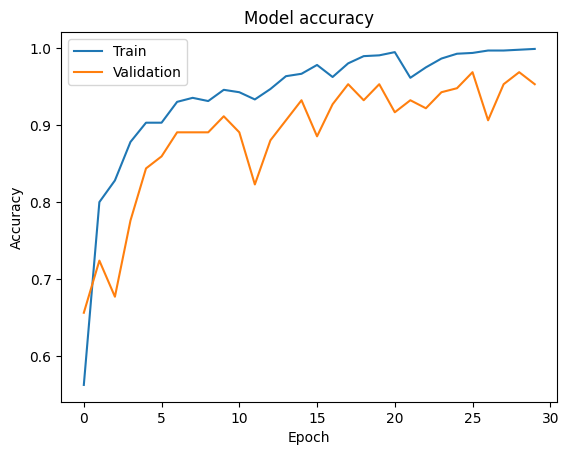

In [11]:
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('accuracy.png')
plt.show()

## Loss Curve

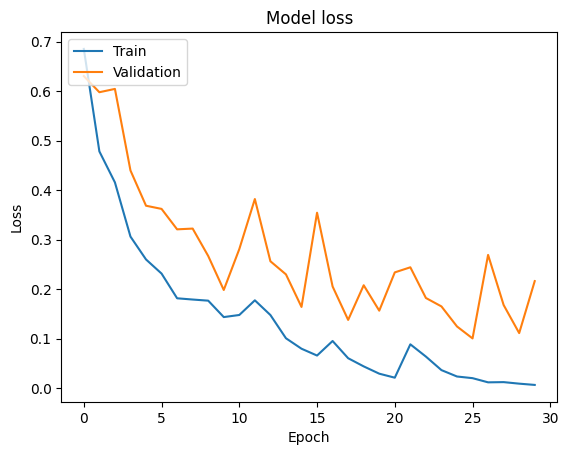

In [12]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('loss.png')
plt.show()

## Model Evaluation
Accuracy is 95%

In [13]:
# model evaluation
best_model = load_model('artifacts/model.h5')

results = best_model.evaluate(validation_generator)

scores = {'loss': results[0], 'accuracy': results[1]}

try:
    with open('scores.json', 'w') as json_file:
        json.dump(scores, json_file)
except IOError as e:
    raise IOError(f"An error occurred while writing to the file: {e}")

4/4 [==============================] - 4s 1s/step - loss: 0.1562 - accuracy: 0.9583


4/4 [==============================] - 4s 945ms/step


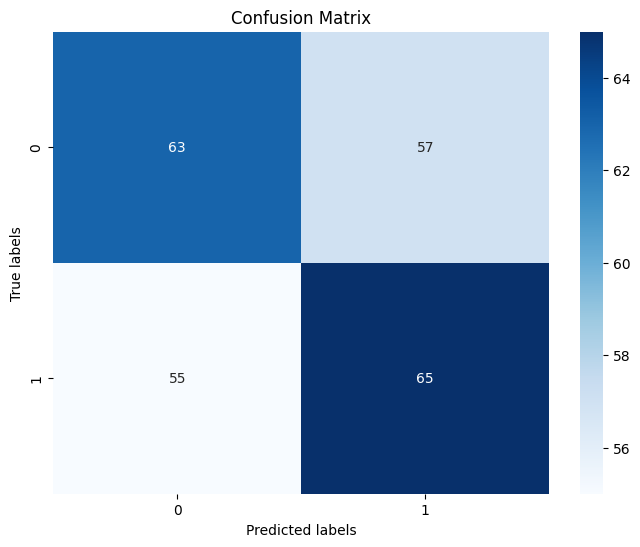

In [21]:
best_model = load_model('artifacts/model.h5')
predictions = best_model.predict(validation_generator)
predicted_labels = np.argmax(predictions, axis=1)

true_labels = validation_generator.classes

class_names = list(validation_generator.class_indices.keys())

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.savefig('matrix.png')
plt.show()

## Logging best hyperparameters and model metrics to mlflow (Experiment Tracking)

In [15]:
# mlflow configs
os.environ["MLFLOW_TRACKING_URI"]= MLFLOW_TRACKING_URI
os.environ["MLFLOW_TRACKING_USERNAME"]= MLFLOW_TRACKING_USERNAME
os.environ["MLFLOW_TRACKING_PASSWORD"]= MLFLOW_TRACKING_PASSWORD

In [16]:
mlflow.set_registry_uri(MLFLOW_TRACKING_URI)
tracking_url_type_store= urlparse(mlflow.get_tracking_uri()).scheme

with mlflow.start_run():
    mlflow.log_params(params)
    mlflow.log_metrics(
        {"loss": results[0], "accuracy": results[1]}
    )

    if tracking_url_type_store != "file":
        mlflow.keras.log_model(best_model, "model", registered_model_name="MSV-Model")
    else:
        mlflow.keras.log_model(best_model, "model")

2024/04/28 16:32:13 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Registered model 'MSV-Model' already exists. Creating a new version of this model...
2024/04/28 16:32:38 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: MSV-Model, version 2
Created version '2' of model 'MSV-Model'.


## Sample prediction

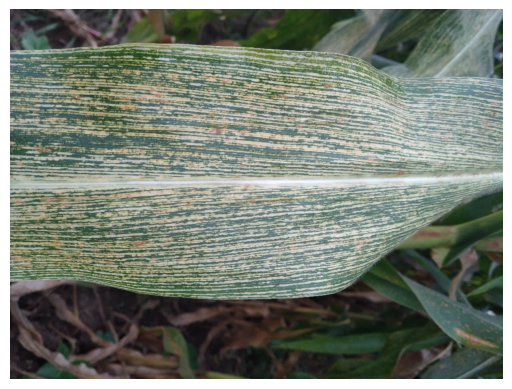

1/1 [==============================] - 0s 492ms/step
Top Label: Maize Streak Virus Present
score: [0.3167656  0.68323433]


In [17]:
image = cv2.imread('/content/content/msv_dataset/1/1621319189136.jpg')
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.axis('off')
plt.show()
# Preprocess the image
image = cv2.resize(image, (224, 224))
image = image.astype('float32') / 255
image = img_to_array(image)
image = np.expand_dims(image, axis=0)

# Define the prediction function
def prediction_function(image):
    best_model = load_model('artifacts/model.h5')
    return best_model.predict(image)

predictions = prediction_function(image)

class_names = ['Healthy', 'Maize Streak Virus Present']
score = tf.nn.softmax(predictions[0])
print(f"Top Label: {class_names[np.argmax(score)]}")
print(f"score: {score}")